# Importing libraries

In [2]:
!pip install rpy2==2.9.6b

     |████████████████████████████████| 194kB 5.8MB/s 
  Created wheel for rpy2: filename=rpy2-2.9.6b0-cp36-cp36m-linux_x86_64.whl size=316075 sha256=62d799aaaafe9b65f6cd9be3f1228e6b0fbd36673651e842dc8fd835c6771820
  Stored in directory: /root/.cache/pip/wheels/02/d6/dc/8c3faafb8cb7165a30d67f899ff7e88766e20260dda41ace88
Successfully built rpy2
  Found existing installation: rpy2 3.2.7
    Uninstalling rpy2-3.2.7:
      Successfully uninstalled rpy2-3.2.7


In [3]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
%%R
install.packages("grf")



R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘zoo’, ‘DiceKriging’, ‘lmtest’, ‘sandwich’, ‘RcppEigen’


R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/zoo_1.8-8.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 849487 bytes (829 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

In [5]:
!pip install justcause==0.3.2

     |████████████████████████████████| 51kB 2.6MB/s 
     |████████████████████████████████| 245kB 6.9MB/s 
     |████████████████████████████████| 1.8MB 28.3MB/s 
     |████████████████████████████████| 327kB 24.2MB/s 
  Created wheel for causalml: filename=causalml-0.9.0-cp36-cp36m-linux_x86_64.whl size=482223 sha256=bc4708d1ed666ae6a8e32f8058ff5a557e42749d9d23b90b03f3e8b833d52865
  Stored in directory: /root/.cache/pip/wheels/6d/c4/e2/451f0ebc2f9a7540256b0a705a2fd09864893131aee58d5af9
  Created wheel for shap: filename=shap-0.37.0-cp36-cp36m-linux_x86_64.whl size=463928 sha256=38e660c5ce5e8793f7915a3958b31fb1433aaadb55204069a087718b225b6965
  Stored in directory: /root/.cache/pip/wheels/df/ad/b0/aa7815ec68850d66551ef618095eccb962c8f6022f1d3dd989
Successfully built causalml shap


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
from justcause.data import Col
from justcause.data.sets import load_ihdp
from justcause.metrics import pehe_score, mean_absolute
from justcause.evaluation import calc_scores, summarize_scores

In [ ]:
%load_ext autoreload

%autoreload 2

# Loading all required packages 
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#### Infant Health Development Program Data-Set used in this exercise

- Original study constructed to study the effect of special child care for low birthweight, premature infants.
- In total, six continuous and 19 binary pretreatment variables
- Using the covariates of all instances in both treatment groups, the potential outcomes are generated synthetically
- Finally, manipulation of observational study by omitting a non-random set of samples from the treatment group.
- The way the subset is generated from the experimental data does not ensure complete overlap - latent confounder
- Specifically, the observational subset is created by throwing away the set of all children with nonwhite mothers from the treatment group
- Following data generation process used for potentia outcomes
- After the adaptions from Hill, we are left with 139 instances in the treated group and 608 instances in the control group.

# 1. Running the causal models

In [ ]:
# We Import the IHDP data-set 
# There are 1000 replications in this data-set, each with a different individual treament effect
# produced from an underlying generative function. 
# Check out https://justcause.readthedocs.io/en/latest/


# We load 100 of the 1000 data-sets
replications = load_ihdp(select_rep=np.arange(100))

In [ ]:
# Defining global parameters
train_size = 0.8        # Size of the training data-set 
random_state = 42        # Setting the random state

n= 0       # number of the data-sets we look at 

metrics = [pehe_score, mean_absolute]    ## Defining the metrics that will be calculated below

## 1.1 S-Learner Linear Regression

In [ ]:
# Importing the relevant SLearner module

from justcause.learners import SLearner


# Defining the S-Learner function that returns the ITE
# We define a function that takes the data, splits it up and returns individual treatment effect accuracies for the train and the test data-set
# The function takes each, the train and test data separately and selects the relevant variales and coverts them into np arrays
# The relevant variables have the followings names: x (the covariates), t (the treatment), y (the outcome)
# Note that the treatment needs to be explicityl defined



def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    slearner = model     # Select linear regression as a method to find the ITE for the S-Learner
    slearner.fit(train_X, train_t, train_y)      # Fitting the s-learner with linear regression
    return (
        slearner.predict_ite(train_X, train_t, train_y),   # Returning the predicting values for ITE for train
        slearner.predict_ite(test_X, test_t, test_y)       # Returning the prediction values for ITE for test
    )



In [ ]:
results_df = list()     # We define the list that contains the results
test_scores = list()    # Storing the test scores in a list
train_scores = list()   # Storing the train scores in a list


# Here we define the model that is going to be used for the S-learner
# Please instantiate linear regression for the simple learner


##-----------------Question------------------###
# Pass a LinearRegression Model into the S-Learner
# No particular parameter-settings necessary


model=SLearner()


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_slearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'S-Learner LR', 'train': True})
test_result.update({'method': 'S-Learner LR', 'train': False})

In [ ]:
df_S_learner_LR=pd.DataFrame([train_result, test_result])
df_S_learner_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.633660,2.623297,8.362125,0.732443,0.238185,1.493276,S-Learner LR,True
1,5.625971,2.635993,8.213626,1.292668,0.396246,2.474603,S-Learner LR,False


### 1.1.1 S-Learner Visualization

In [ ]:
# We run the same analysis again but only on an indvidual run of the data
# The reason is that the data generating process is varied every time,... 
# ...so we can only look at individual runs of the ITE effect
results_df = list()    # We define the list that contains the results
test_scores = list()   # Storing the test scores in a list
train_scores = list()  # Storing the train scores in a list


#for rep in replications:

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state     # Use train_test_split  to split the data-set (replications[n]) 
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_slearner(train, test, model)         # using the pre-defined basic learner function to retunr train, test

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))    # Using the just cause API to calcualte the scores from the estimate ITE for the training data
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))     # Using the just cause API to calcualte the scores from the estimate ITE for the test data

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)   #summary of the scores 
train_result.update({'method': 'S-Learner LR', 'train': True})
test_result.update({'method': 'S-Learner LR', 'train': False})


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


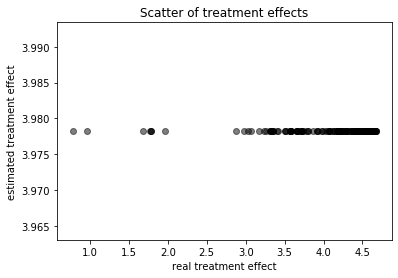

In [ ]:
# Importing Matplotlib 
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

# If the treatment effect is perfectly represented there should be a 45 degree line!

## QUESTION 1

IS THE S-LEARNER WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

## 1.2 Propensity Score Weighing with Linear Regression

In [ ]:
# Importing the relevant PSWEstimator

from justcause.learners import PSWEstimator


#Defining the Propoensity Score weighing function that returns the ITE

def propensity_score_weighing(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    pswestimator = model

    return (
        pswestimator.estimate_ate(train_X, train_t, train_y),
        pswestimator.estimate_ate(test_X, test_t, test_y)
    )


In [ ]:
results_df = list()
test_scores = list()
train_scores = list()




model = PSWEstimator(propensity_learner=None, delta=0.001)


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = propensity_score_weighing(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'PSW', 'train': True})
test_result.update({'method': 'PSW', 'train': False})

In [ ]:
df_PSW_LR=pd.DataFrame([train_result, test_result])
df_PSW_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.595322,2.537818,8.244302,0.412006,0.284332,0.457697,PSW,True
1,6.837997,3.484394,8.323623,3.783440,2.649187,3.225824,PSW,False


## 1.3 S-Learner Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


# Importing the relevant S-Learner estimator
from justcause.learners import SLearner


#Defining the S-Learner function that returns the ITE

def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    slearner = model  
    slearner.fit(train_X, train_t, train_y)
    return (
        slearner.predict_ite(train_X, train_t, train_y),
        slearner.predict_ite(test_X, test_t, test_y)
    )


In [ ]:
results_df = list()
test_scores = list()
train_scores = list()

#---------------------------Question--------------------------------#
# Pass a RandomForestRegressor into the S-learner



model = SLearner()

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_slearner(train, test, model )

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'S-Learner RF', 'train': True})
test_result.update({'method': 'S-Learner RF', 'train': False})

In [ ]:
df_S_learner_RF=pd.DataFrame([train_result, test_result])
df_S_learner_RF

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,3.133693,1.047904,4.861394,0.511598,0.125918,0.971366,S-Learner RF,True
1,3.320106,1.234456,5.197415,0.451143,0.137152,1.047357,S-Learner RF,False


### 1.3.1 Random Forest Visualization

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


# Importing the relevant SLearner module
from justcause.learners import SLearner


#Defining the S-Learner function that returns the ITE

def basic_slearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    slearner = model
    slearner.fit(train_X, train_t, train_y)
    return (
        slearner.predict_ite(train_X, train_t, train_y),
        slearner.predict_ite(test_X, test_t, test_y)
    )

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


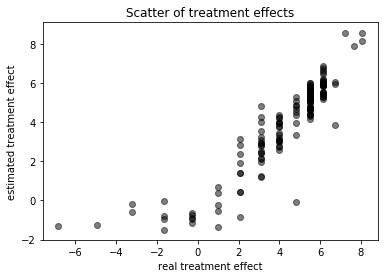

In [ ]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 2

IS THE S-LEARNER WITH RANDOM FOREST ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

## 1.4 T-Learner Linear Regression

In [ ]:
# Importing the relevant SLearner module

from justcause.learners import TLearner


#Defining the S-Learner function that returns the ITE

def basic_tlearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    tlearner = model
    tlearner.fit(train_X, train_t, train_y)
    return (
        tlearner.predict_ite(train_X, train_t, train_y),
        tlearner.predict_ite(test_X, test_t, test_y)
    )



In [ ]:
results_df = list()
test_scores = list()
train_scores = list()

#------------------Question------------------------------#
# Pass linear regression into the T-Learner



tlearner = TLearner()

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_tlearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})

In [ ]:
df_T_learner_LR=pd.DataFrame([train_result, test_result])
df_T_learner_LR

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,3.106716,1.05165,4.788258,0.500543,0.124951,0.933657,T-Learner LR,True
1,3.311096,1.26711,5.155404,0.445728,0.134426,1.022285,T-Learner LR,False


### 1.4.1 T-Learner Linear Regression Visualization

In [ ]:
results_df = list()
test_scores = list()
train_scores = list()

train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_tlearner(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner LR', 'train': True})
test_result.update({'method': 'T-Learner LR', 'train': False})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


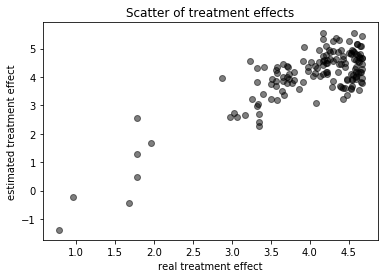

In [ ]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 3

IS THE T-LEARNER WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

## 1.5 T-Learner Random Forest

In [ ]:
# Importing the relevant SLearner module

from justcause.learners import TLearner


#Defining the S-Learner function that returns the ITE

def basic_tlearner(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    tlearner = model
    tlearner.fit(train_X, train_t, train_y)
    return (
        tlearner.predict_ite(train_X, train_t, train_y),
        tlearner.predict_ite(test_X, test_t, test_y)
    )



In [ ]:
results_df = list()
test_scores = list()
train_scores = list()

#--------------------Question----------------------------------#
# Pass a Random Forest into the T-Learner

model = TLearner()

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = basic_tlearner(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

NameError: ignored

In [ ]:
df_T_learner_RF=pd.DataFrame([train_result, test_result])
df_T_learner_RF

NameError: ignored

### 1.5.1 T-Learner with Random Forrest Visualization

In [ ]:
results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = basic_tlearner(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


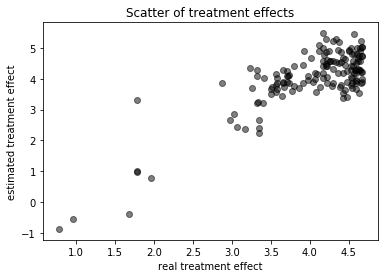

In [ ]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 4

IS THE T-LEARNER WITH RANDOM FOREST ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

## 1.6 Causal Forest

In [ ]:
# Importing the relevant SLearner module

from justcause.learners import CausalForest


#Defining the S-Learner function that returns the ITE

def causal_forest(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    causalforest = model
    causalforest.fit(train_X, train_t, train_y)
    return (
        causalforest.predict_ite(train_X, train_t, train_y),
        causalforest.predict_ite(test_X, test_t, test_y)
    )


In [ ]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()

model = CausalForest(random_state=random_state)

for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = causal_forest(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

In [ ]:
df_causal_forest=pd.DataFrame([train_result, test_result])
df_causal_forest

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,4.172661,1.921242,6.330031,0.441738,0.198733,0.823171,T-Learner RF,True
1,4.378083,1.797608,6.606150,0.683703,0.233695,1.354973,T-Learner RF,False


### 1.6.1 Causal Forest Visualization 

In [ ]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = causal_forest(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'T-Learner RF', 'train': True})
test_result.update({'method': 'T-Learner RF', 'train': False})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


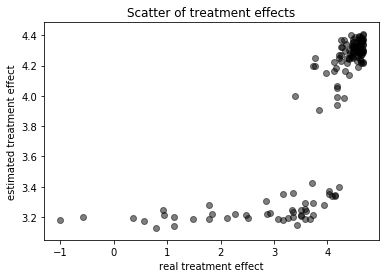

In [ ]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 5

IS THE CAUSAL FOREST WITH LINEAR REGRESSION ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

## 1.7 Neural Network

In [ ]:
# Importing the relevant SLearner module

from justcause.learners import DragonNet


#Defining the S-Learner function that returns the ITE

def causal_forest(train, test, model):
    """ """
    train_X, train_t, train_y = train.np.X, train.np.t, train.np.y
    test_X, test_t, test_y = test.np.X, test.np.t, test.np.y

    dragonnet = model
    dragonnet.fit(train_X, train_t, train_y)
    return (
        dragonnet.predict_ite(train_X, train_t, train_y),
        dragonnet.predict_ite(test_X, test_t, test_y)
    )


In [ ]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()


#---------------------------Question----------------------------#
# Set the model to the DragonNet neural network from JustCause


model = 


for rep in replications:

    train, test = train_test_split(
        rep, train_size=train_size, random_state=random_state
    )

    # REPLACE this with the function you implemented and want to evaluate
    train_ite, test_ite = causal_forest(train, test, model)

    # Calculate the scores and append them to a dataframe
    train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
    test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Dragonnet', 'train': True})
test_result.update({'method': 'Dragonnet', 'train': False})

Using TensorFlow backend.


Streaming output truncated to the last 5000 lines.
Epoch 48/50
537/537 [==============================] - 0s 61us/step - loss: 1628.4845 - regression_loss: 691.1127 - val_loss: 276.8921 - val_regression_loss: 120.7643
Epoch 49/50
537/537 [==============================] - 0s 77us/step - loss: 1622.6759 - regression_loss: 689.6605 - val_loss: 275.0143 - val_regression_loss: 119.7951
Epoch 50/50
537/537 [==============================] - 0s 70us/step - loss: 1558.4554 - regression_loss: 657.8106 - val_loss: 273.3792 - val_regression_loss: 118.9410
***************************** elapsed_time is:  3.818852663040161
Train on 537 samples, validate on 60 samples
Epoch 1/50
537/537 [==============================] - 1s 2ms/step - loss: 171939.8187 - regression_loss: 86364.8814 - val_loss: 17097.1992 - val_regression_loss: 8591.0752
Epoch 2/50
537/537 [==============================] - 0s 62us/step - loss: 149083.0884 - regression_loss: 74918.7058 - val_loss: 14047.2402 - val_regression_loss: 70

In [ ]:
df_dragonnet=pd.DataFrame([train_result, test_result])
df_dragonnet

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,2.919889,1.107028,4.972546,0.826205,0.353679,1.817544,Dragonnet,True
1,3.036828,1.033174,4.930624,0.925162,0.348241,2.146797,Dragonnet,False


### 1.7.1 Neura Network Visualization

In [ ]:
random_state = 1

results_df = list()
test_scores = list()
train_scores = list()



train, test = train_test_split(
        replications[n], train_size=train_size, random_state=random_state
    )

# REPLACE this with the function you implemented and want to evaluate
train_ite, test_ite = causal_forest(train, test, model)

# Calculate the scores and append them to a dataframe
train_scores.append(calc_scores(train[Col.ite], train_ite, metrics))
test_scores.append(calc_scores(test[Col.ite], test_ite, metrics))

# Summarize the scores and save them in a dataframe
train_result, test_result = summarize_scores(train_scores), summarize_scores(test_scores)
train_result.update({'method': 'Dragonnet', 'train': True})
test_result.update({'method': 'Dragonnet', 'train': False})

Train on 537 samples, validate on 60 samples
Epoch 1/50
537/537 [==============================] - 1s 2ms/step - loss: 14622.1565 - regression_loss: 7142.0761 - val_loss: 1554.1144 - val_regression_loss: 755.8400
Epoch 2/50
537/537 [==============================] - 0s 63us/step - loss: 10591.8192 - regression_loss: 5141.3342 - val_loss: 1069.6041 - val_regression_loss: 514.9556
Epoch 3/50
537/537 [==============================] - 0s 74us/step - loss: 7188.3933 - regression_loss: 3450.9330 - val_loss: 747.3391 - val_regression_loss: 355.0568
Epoch 4/50
537/537 [==============================] - 0s 58us/step - loss: 5443.8089 - regression_loss: 2587.9504 - val_loss: 519.1975 - val_regression_loss: 241.8520
Epoch 5/50
537/537 [==============================] - 0s 58us/step - loss: 3824.1067 - regression_loss: 1785.5284 - val_loss: 324.8045 - val_regression_loss: 144.9832
Epoch 6/50
537/537 [==============================] - 0s 67us/step - loss: 2084.9452 - regression_loss: 918.4310 - va

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


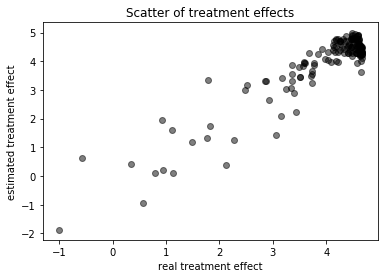

In [ ]:
import matplotlib.pyplot as plt
colors = (0,0,0)
# Plot
plt.scatter(test.np.ite, test_ite,  c=colors, alpha=0.5)
plt.title('Scatter of treatment effects')
plt.xlabel('real treatment effect')
plt.ylabel('estimated treatment effect')
plt.show()

## QUESTION 6

IS THE DRAGONNET NEURAL NETWORK ESTIMATING INDIVIDUAL TREATMENT EFFECTS WELL? IF YES/NO -WHY SO?

## 1.8 Comparison of the methods

In [ ]:
pd.concat([df_S_learner_LR, df_PSW_LR, df_S_learner_RF, df_T_learner_LR, df_T_learner_RF, df_causal_forest, df_dragonnet ], ignore_index=True)

,pehe_score-mean,pehe_score-median,pehe_score-std,mean_absolute-mean,mean_absolute-median,mean_absolute-std,method,train
0,5.633660,2.623297,8.362125,0.732443,0.238185,1.493276,S-Learner LR,True
1,5.625971,2.635993,8.213626,1.292668,0.396246,2.474603,S-Learner LR,False
2,5.595322,2.537818,8.244302,0.412006,0.284332,0.457697,PSW,True
3,6.837997,3.484394,8.323623,3.783440,2.649187,3.225824,PSW,False
4,3.133693,1.047904,4.861394,0.511598,0.125918,0.971366,S-Learner RF,True
5,3.320106,1.234456,5.197415,0.451143,0.137152,1.047357,S-Learner RF,False
6,3.106716,1.051650,4.788258,0.500543,0.124951,0.933657,T-Learner LR,True
7,3.311096,1.267110,5.155404,0.445728,0.134426,1.022285,T-Learner LR,False
8,1.783826,0.947208,2.263913,0.130565,0.104154,0.130342,T-Learner RF,True
9,2.512660,1.109184,3.501475,0.210897,0.123812,0.277706,T-Learner RF,False




```
# This is formatted as code
```

## QUESTION 7

HOW DO THE DIFFERENT MODELS COMPARE IN TERMS OF MEAN PEHE ACCURACY? WHAT ASPECTS DO YOU THINK DETERMINE WHETHER ONE MODEL PERFOMS BETTER THAN ANOTER?